## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)



<a id='probability'></a>
#### Part I - Probability



In [45]:
# import libraries
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

1a

In [2]:
# read in data set an create data frame
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


1b

In [3]:
# number of rows in dataset
df.shape

(294478, 5)

1c

In [4]:
# number of unique users in dataset
df['user_id'].nunique()

290584

1d

In [5]:
# proportion of users converted
df['converted'].mean()

0.11965919355605512

1e

In [6]:
# number of not matches of new_page and treatment and old_page and control
df.query('group == "control" & landing_page == "new_page" or group == "treatment" & landing_page == "old_page"').count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

1f

In [7]:
# assess for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


2a

In [8]:
# delete rows where control and old_page and treatment and new_page do not match
df2 = df.query('group == "control" & landing_page == "old_page" or group == "treatment" & landing_page == "new_page"')

2b

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

3a

In [10]:
# number of unique users in df2
df2['user_id'].nunique()

290584

3b

In [11]:
# create filter for duplicated user
fil = df2['user_id'].duplicated()
df2[fil]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


3c

In [12]:
# display duplicated rows
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


3d

In [13]:
# remove duplication
df2.drop([1899], axis=0, inplace=True)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
# control success
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


4a

In [15]:
# probability of converting regardless of received page
df2['converted'].mean()

0.11959708724499628

4b

In [16]:
# create data frame for control group
df_control = df2[df2['group'] == 'control']
df_control.shape

(145274, 5)

In [17]:
# probability of conversion of control group
df_control_convrate = df_control['converted'].mean()
df_control_convrate

0.1203863045004612

4c

In [18]:
# create data frame for treatment group
df_treatment = df2[df2['group'] == 'treatment']
df_treatment.shape

(145310, 5)

In [19]:
# probability of conversion of treatment group
df_treatment_convrate = df_treatment['converted'].mean()
df_treatment_convrate

0.11880806551510564

In [20]:
# calculate observed difference for sample
obs_diff = df_treatment_convrate - df_control_convrate
obs_diff

-0.0015782389853555567

4d

In [21]:
# probability of receiving new page
df2[df2['landing_page'] == 'new_page']['landing_page'].count()/df2['landing_page'].count()

0.5000619442226688

4e

**From the above lines I conclude that there probably is not enough evidence to support the hypothesis that the new page generates more conversions. First, there seems to be a higher conversion rate in the control group in the sample, which also renders the observed difference negativ.**

<a id='ab_test'></a>
### Part II - A/B Test

1

H0: **$p_{new}$**- **$p_{old}$** =< 0

H1: **$p_{new}$** - **$p_{old}$** > 0

2a

In [22]:
# conversion rate for p_new under the null
df2.converted.mean()

0.11959708724499628

2b

In [23]:
# conversion rate for p_old under the null
df2.converted.mean()

0.11959708724499628

2c

In [24]:
# number of individuals in treatment group n_new
df_treatment.shape[0]

145310

2d

In [25]:
# number of individuals in control group n_old
df_control.shape[0]

145274

2e

In [26]:
# simulate n_new transactions under the null and store results
new_page_converted = df_treatment.sample(df_treatment.shape[0], replace = True)

2f

In [27]:
# simulate n_old transactions under the null and store results
old_page_converted = df_control.sample(df_control.shape[0], replace = True)

2g

In [28]:
# calculate difference in sampled conversion mean for treatment and control group part 1
p_new = new_page_converted.converted.mean()
p_new

0.11970958640148648

In [29]:
# calculate difference in sampled conversion mean for treatment and control group part 2
p_old = old_page_converted.converted.mean()
p_old

0.12167352726571858

In [30]:
# calculate difference in sampled conversion mean for treatment and control group part 3
obs_diff1 = p_new - p_old
obs_diff1

-0.0019639408642321

2h

In [31]:
# create a sample distribution with bootstrapping for differences in conversion mean between treatment and control group
p_diffs = []
for _ in range(10000):
    new_page_converted = df_treatment.sample(df_treatment.shape[0], replace = True)
    old_page_converted = df_control.sample(df_control.shape[0], replace = True)
    p_new = new_page_converted.converted.mean()
    p_old = old_page_converted.converted.mean()
    p_diffs.append(p_new - p_old)

In [32]:
# convert list to numpy array
p_diffs = np.array(p_diffs)

2i

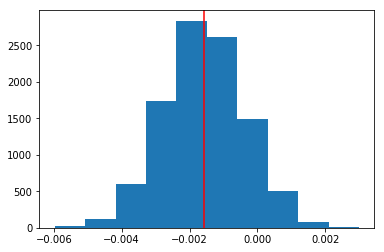

In [33]:
# plot sample distribution
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color = 'red');

**The plot looks like what I am expected because it is centered around the observed difference which should be an indicator for where the value range of the parameter will be. Furthermore, it is normally distributed which would be expected from the central limit theorem.**

**The sampling distribution from the null hypothesis looks like expected. Centered around 0 and normally distributed. The observed difference of the sample falls within the range of the null hypothesis distribution. This indicates that we cannot reject the null hypothesis.**

2j

In [34]:
# calculate p value i.e. proportion of sample distribution differences that are greater than observed difference
(p_diffs > obs_diff).mean()

0.5009

2k

**In 2j we computed the p-value. The p-value is a measure of the probability of finding statistics equal to or greater than the observed difference from the null given H0 is true. This means if p -value is large H0 cannot be rejected and if it is small H0 can be rejected. Whether it is considered large or small depends on alpha. In this case alpha is 5% or 0.05. Therefore, the p-value is greater than alpha and H0 cannot be rejected. According to the hypotheses we stated we can conclude that there seems to be no difference between the two pages concerning conversion rates. Therefore, the new page should not be introduced for the reason of increasing conversion rates.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [35]:
# build 2 data frames of converted users from treatment and control group
df_treatment_conv = df_treatment[df_treatment['converted'] == 1]
df_control_conv = df_control[df_control['converted'] == 1]

In [36]:
# define parameters to be used in Z Test
convert_old = df_control_conv.shape[0]
convert_new = df_treatment_conv.shape[0]
n_old = df_control.shape[0]
n_new = df_treatment.shape[0]
value = 0
count = np.array([convert_old, convert_new])
nobs = np.array([n_old, n_new])
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

2m

In [37]:
# compute test statistic and p value with Z test
stats, pval = sm.stats.proportions_ztest(count, nobs, value)
stats, pval

(1.3109241984234394, 0.18988337448195103)

2n

**Like in 2j and 2k the p - value does not show statistical significance as it is > than alpha of 0.05. Therefore, H0 cannot be rejected. Thus, also this statistic tells us that the conversion rate does not seem to increase with the new page. The z-score is not considered as it is used to calculate the p - value and hence will not deviate from the evidence of the p -value.**

<a id='regression'></a>
### Part III - A regression approach


1a Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**I will perform Logistic Regression since there is only the possibility of 0 or 1 i.e. no conversion or conversion**

1b

In [38]:
# ad an intercept and dummy variables as a preparation for the regression
df2['intercept'] = 1
df2[['x', 'ab_page']] = pd.get_dummies(df['group'])

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Applications/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [39]:
# inspect data
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,x,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


1c 

In [43]:
# create logistic regression model to predict conversion depending on page displayed
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
# fit model
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [46]:
# show results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 10 Apr 2019   Pseudo R-squ.:               8.077e-06
Time:                        21:13:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

1e

**Interpretation: The p value of ab_page of 0.19 tells us that this variable is not statistically significant. In other words we have no effect on conversion rate from the type of page (old or new) we receive. This again shows us that we do not need to launch the new page because thereseems to be no effect on the conversion rate. The difference between the p-value of the logistic regression and the p-value of the hypothesis testing in Part II stems from the differences in the hypotheses. In Part II the hypotheses were mathematically derived from the differences of the probabilities of conversion dependend on the old page and the new page whereas in the logistic regression model the hypotheses are mathematically derived from the probability of converting depending on the kind of page displayed (old or new)**

1f

**Discussion of using additional items: As the conversion rate is not influenced by the page design it is a good idea to consider other factors in order to use the gathered data to their full extent. Otherwise the efforts in gathering the data would be wasted. It is for sure easier and cheaper to do analyses of existent data than to gather data. The caveat is that with adding additional items to a regression model one of these items may be statistically signifcant just by chance.**

1g

In [42]:
# read in country data
df_country = pd.read_csv('countries.csv')
# inspect data
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [47]:
# inspect which countries are recorded
df_country.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [48]:
# inspect data
df_country.shape

(290584, 2)

In [49]:
# sort values for merging data frames
df2_sorted = df2.sort_values(by=['user_id'])
# inspect data
df2_sorted.head()

,user_id,timestamp,group,landing_page,converted,intercept,x,ab_page
63114,630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1
103873,630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1
205236,630002,2017-01-19 19:20:56.438330,control,old_page,0,1,1,0
247344,630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1
242283,630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1


In [50]:
# reset index
df2_sort_idx = df2_sorted.reset_index(drop=True)
# inspect data
df2_sort_idx.head()

,index,user_id,timestamp,group,landing_page,converted,intercept,x,ab_page
0,63114,630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1
1,103873,630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1
2,205236,630002,2017-01-19 19:20:56.438330,control,old_page,0,1,1,0
3,247344,630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1
4,242283,630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1


In [52]:
# sort values for merging data frames
df_country_sorted = df_country.sort_values(by=['user_id'])
# inspect data
df_country_sorted.head()

,user_id,country
101274,630000,US
23584,630001,US
138444,630002,US
21396,630003,US
105911,630004,US


In [53]:
# reset index
df_count_idx = df_country_sorted.reset_index(drop=True)
# inspect data
df_count_idx.head()

,index,user_id,country
0,101274,630000,US
1,23584,630001,US
2,138444,630002,US
3,21396,630003,US
4,105911,630004,US


In [54]:
# drop user id as it is already contained in df2
df_count_idx.drop(['user_id'], axis=1, inplace=True)
# inspect data
df_count_idx.head()

,country
0,US
1,US
2,US
3,US
4,US


In [ ]:
# merge data frames
df_merged = pd.concat([df2_sort_idx, df_count_idx], axis=1)
# inspect data
df_merged.head()

In [ ]:
# get dummy variables for the different countries
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])
# inspect data
df_merged.head()

In [ ]:
# create logistic regression model to predict conversion depending on country
logit_mod1 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'UK', 'US']])
# fit model
results1 = logit_mod1.fit()

In [ ]:
# show results
results1.summary()

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [ ]:
logit_mod2 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US']])
results2 = logit_mod2.fit()

In [ ]:
results2.summary()

**Incorporate time data**

In [ ]:
df_merged['timestamp'].max(), df_merged['timestamp'].min()

In [ ]:
df_merged.info()

In [ ]:
df_merged['Timestamp'] = pd.to_datetime(df_merged['timestamp'])

In [ ]:
df_merged['weekday'] = df_merged['Timestamp'].apply(lambda x: x.weekday())
df_merged.head()

In [ ]:
bin_edges = [-1, 4, 6]
bin_labels = ['weekday', 'weekend']

In [ ]:
df_merged['weekend'] = pd.cut(df_merged['weekday'], bin_edges, labels=bin_labels )
df_merged

In [ ]:
df_merged[['weekday_1', 'weekend_1' ]] = pd.get_dummies(df_merged['weekend'])

In [ ]:
df_merged.head()

In [ ]:
df_merged[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']] = pd.get_dummies(df_merged['weekday'])

In [ ]:
df_merged.head()

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])